# Tokenizers
okenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data. In this section, we’ll explore exactly what happens in the tokenization pipeline.

In NLP tasks, the data that is generally processed is raw text. Here’s an example of such text:

In [2]:
"Jim Henson was a puppeteer"

'Jim Henson was a puppeteer'

However, models can only process numbers, so we need to find a way to convert the raw text to numbers. That’s what the tokenizers do, and there are a lot of ways to go about this. The goal is to find the most meaningful representation — that is, the one that makes the most sense to the model — and, if possible, the smallest representation.

Let’s take a look at some examples of tokenization algorithms, and try to answer some of the questions you may have about tokenization.

## Word based

The first type of tokenizer that comes to mind is word-based. It’s generally very easy to set up and use with only a few rules, and it often yields decent results. For example, in the image below, the goal is to split the raw text into words and find a numerical representation for each of them:

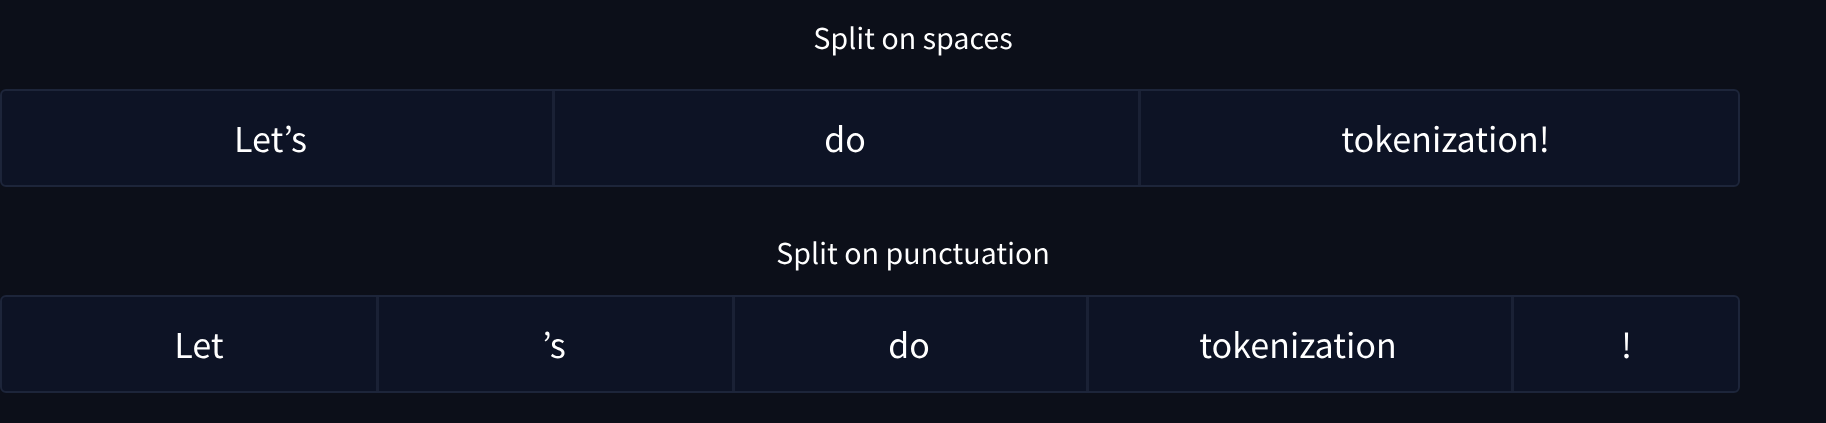

There are different ways to split the text. For example, we could use whitespace to tokenize the text into words by applying Python’s split() function:

In [3]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

['Jim', 'Henson', 'was', 'a', 'puppeteer']



There are also variations of word tokenizers that have extra rules for punctuation. With this kind of tokenizer, we can end up with some pretty large “vocabularies,” where a vocabulary is defined by the total number of independent tokens that we have in our corpus.

Each word gets assigned an ID, starting from 0 and going up to the size of the vocabulary. The model uses these IDs to identify each word.

If we want to completely cover a language with a word-based tokenizer, we’ll need to have an identifier for each word in the language, which will generate a huge amount of tokens. For example, there are over 500,000 words in the English language, so to build a map from each word to an input ID we’d need to keep track of that many IDs. Furthermore, words like “dog” are represented differently from words like “dogs”, and the model will initially have no way of knowing that “dog” and “dogs” are similar: it will identify the two words as unrelated. The same applies to other similar words, like “run” and “running”, which the model will not see as being similar initially.

Finally, we need a custom token to represent words that are not in our vocabulary. This is known as the “unknown” token, often represented as ”[UNK]” or ”<unk>”. It’s generally a bad sign if you see that the tokenizer is producing a lot of these tokens, as it wasn’t able to retrieve a sensible representation of a word and you’re losing information along the way. The goal when crafting the vocabulary is to do it in such a way that the tokenizer tokenizes as few words as possible into the unknown token.

One way to reduce the amount of unknown tokens is to go one level deeper, using a character-based tokenizer.

## character based

Character-based tokenizers split the text into characters, rather than words. This has two primary benefits:

The vocabulary is much smaller.
There are much fewer out-of-vocabulary (unknown) tokens, since every word can be built from characters.
But here too some questions arise concerning spaces and punctuation:

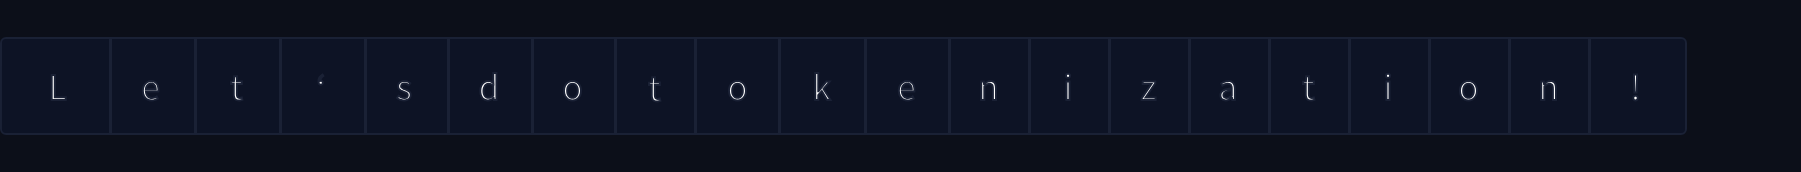

This approach isn’t perfect either. Since the representation is now based on characters rather than words, one could argue that, intuitively, it’s less meaningful: each character doesn’t mean a lot on its own, whereas that is the case with words. However, this again differs according to the language; in Chinese, for example, each character carries more information than a character in a Latin language.

Another thing to consider is that we’ll end up with a very large amount of tokens to be processed by our model: whereas a word would only be a single token with a word-based tokenizer, it can easily turn into 10 or more tokens when converted into characters.

To get the best of both worlds, we can use a third technique that combines the two approaches: subword tokenization.

 ## Subword tokenization

Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords.

For instance, “annoyingly” might be considered a rare word and could be decomposed into “annoying” and “ly”. These are both likely to appear more frequently as standalone subwords, while at the same time the meaning of “annoyingly” is kept by the composite meaning of “annoying” and “ly”.

Here is an example showing how a subword tokenization algorithm would tokenize the sequence “Let’s do tokenization!“:

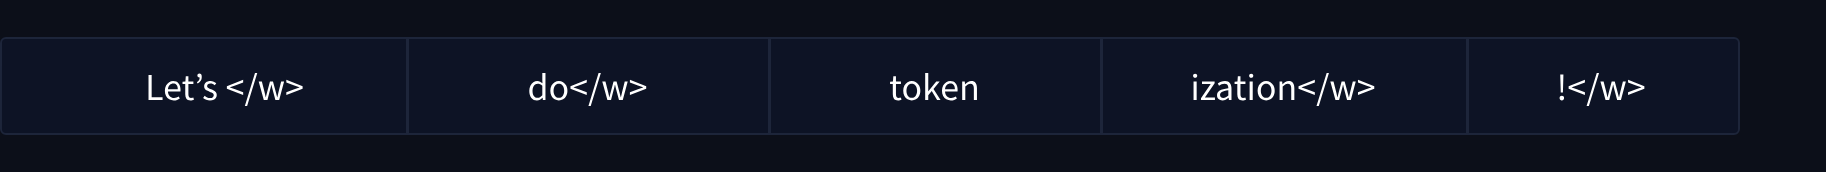

These subwords end up providing a lot of semantic meaning: for instance, in the example above “tokenization” was split into “token” and “ization”, two tokens that have a semantic meaning while being space-efficient (only two tokens are needed to represent a long word). This allows us to have relatively good coverage with small vocabularies, and close to no unknown tokens.

This approach is especially useful in agglutinative languages such as Turkish, where you can form (almost) arbitrarily long complex words by stringing together subwords.

And more!
Unsurprisingly, there are many more techniques out there. To name a few:

    Byte-level BPE, as used in GPT-2
    WordPiece, as used in BERT
    SentencePiece or Unigram, as used in several multilingual models

You should now have sufficient knowledge of how tokenizers work to get started with the API.

## Loading and saving
Loading and saving tokenizers is as simple as it is with models. Actually, it’s based on the same two methods: from_pretrained() and save_pretrained(). These methods will load or save the algorithm used by the tokenizer (a bit like the architecture of the model) as well as its vocabulary (a bit like the weights of the model).

Loading the BERT tokenizer trained with the same checkpoint as BERT is done the same way as loading the model, except we use the BertTokenizer class:

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Similar to AutoModel, the AutoTokenizer class will grab the proper tokenizer class in the library based on the checkpoint name, and can be used directly with any checkpoint:

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

We can now use the tokenizer as shown in the previous section:

In [6]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

Saving a tokenizer is identical to saving a model:

In [9]:
tokenizer.save_pretrained("hidden/lesson4")

('hidden/lesson4/tokenizer_config.json',
 'hidden/lesson4/special_tokens_map.json',
 'hidden/lesson4/vocab.txt',
 'hidden/lesson4/added_tokens.json',
 'hidden/lesson4/tokenizer.json')

We’ll talk more about token_type_ids in Chapter 3, and we’ll explain the attention_mask key a little later. First, let’s see how the input_ids are generated. To do this, we’ll need to look at the intermediate methods of the tokenizer.

## Encoding

Translating text to numbers is known as encoding. Encoding is done in a two-step process: the tokenization, followed by the conversion to input IDs.

As we’ve seen, the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually called tokens. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules that were used when the model was pretrained.

The second step is to convert those tokens into numbers, so we can build a tensor out of them and feed them to the model. To do this, the tokenizer has a vocabulary, which is the part we download when we instantiate it with the from_pretrained() method. Again, we need to use the same vocabulary used when the model was pretrained.

To get a better understanding of the two steps, we’ll explore them separately. Note that we will use some methods that perform parts of the tokenization pipeline separately to show you the intermediate results of those steps, but in practice, you should call the tokenizer directly on your inputs (as shown in the section 2).

## Tokenization
The tokenization process is done by the tokenize() method of the tokenizer:

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


The output of this method is a list of strings, or tokens:



In [11]:
['Using', 'a', 'transform', '##er', 'network', 'is', 'simple']


['Using', 'a', 'transform', '##er', 'network', 'is', 'simple']

This tokenizer is a subword tokenizer: it splits the words until it obtains tokens that can be represented by its vocabulary. That’s the case here with transformer, which is split into two tokens: transform and ##er.

## From tokens to input IDs
The conversion to input IDs is handled by the convert_tokens_to_ids() tokenizer method:

In [12]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


These outputs, once converted to the appropriate framework tensor, can then be used as inputs to a model as seen earlier in this chapter.

## Decoding
Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the decode() method as follows:

In [13]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


Note that the decode method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be extremely useful when we use models that predict new text (either text generated from a prompt, or for sequence-to-sequence problems like translation or summarization).

By now you should understand the atomic operations a tokenizer can handle: tokenization, conversion to IDs, and converting IDs back to a string. However, we’ve just scraped the tip of the iceberg. In the following section, we’ll take our approach to its limits and take a look at how to overcome them.